## Prepare Dataset

In [1]:
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "rps_v2"

train_dir = image_path / "train"
test_dir = image_path / "test"

import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
walk_through_dir(train_dir)

There are 3 directories and 0 images in 'data\rps_v2\train'.
There are 0 directories and 1552 images in 'data\rps_v2\train\paper'.
There are 0 directories and 1566 images in 'data\rps_v2\train\rock'.
There are 0 directories and 1590 images in 'data\rps_v2\train\scissors'.


In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision
from helper.data_setup import create_dataloaders

# train_transform = transforms.Compose([
#     transforms.Resize(size=(224, 224)),
#     transforms.TrivialAugmentWide(num_magnitude_bins=31),
#     transforms.ToTensor()
# ])

# simple_transform = transforms.Compose([
#     transforms.Resize(size=(224, 224)),
#     transforms.ToTensor()
# ])

auto_transform =  torchvision.models.EfficientNet_B0_Weights.DEFAULT.transforms()

BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transform,
    # test_transform=simple_transform,
    batch_size=BATCH_SIZE)

auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## Prepare Pretrained Model

In [3]:
import torchvision, torch

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# for param in model.features.parameters():
#     param.requires_grad = False
    
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
    ).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [4]:
from torchinfo import summary

summary(model=model, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 3]                    --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         64
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         1,448
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           6,004
│    │    └─MBConv: 3-6                              

## Train Model

In [5]:
from torch import nn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

from helper.engine import train
# from engine import trainWithBoard as train

from timeit import default_timer as timer
start_timer = timer()

NUM_EPOCHS = 5

model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS, 
                        device=device
                        )

print(f"Device: {device} | Time: {timer() - start_timer}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0787 | train_acc: 0.9776 | test_loss: 0.0978 | test_acc: 0.9559
Epoch: 2 | train_loss: 0.0245 | train_acc: 0.9930 | test_loss: 2.9706 | test_acc: 0.9045
Epoch: 3 | train_loss: 0.0333 | train_acc: 0.9901 | test_loss: 0.0466 | test_acc: 0.9840
Epoch: 4 | train_loss: 0.0498 | train_acc: 0.9878 | test_loss: 0.0317 | test_acc: 0.9912
Epoch: 5 | train_loss: 0.0177 | train_acc: 0.9954 | test_loss: 0.0067 | test_acc: 0.9992
Device: cuda | Time: 277.1012172000046


## Plot Model

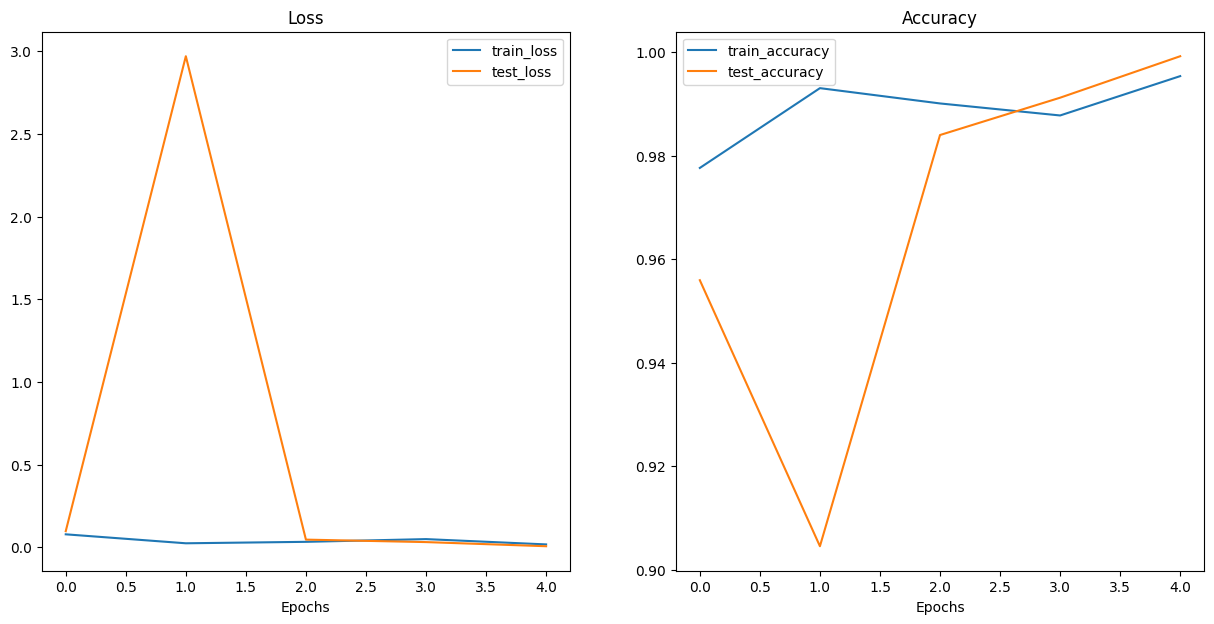

In [6]:
import matplotlib.pyplot as plt

def plot_loss_curves(result: dict[str, list[float]]):
    loss = result["train_loss"]
    test_loss = result["test_loss"]
    
    accuracy = result["train_acc"]
    test_accuracy = result["test_acc"]
    
    epochs = range(len(result["train_loss"]))
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy,label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();
    
plot_loss_curves(model_results)

### Save to .pth

In [7]:
MODEL_PATH = Path("models")
MODEL_NAME = f"RPS2_TransFix_NoGrad_{NUM_EPOCHS}Ep" +".pth"

# from utils import save_model
# save_model(model=model, target_dir=MODEL_PATH, model_name=MODEL_NAME)

## To ONNX

In [8]:
import onnx, onnx_tf, torch
import tensorflow as tf
from pathlib import Path

TFLITE_DIR = MODEL_PATH / "tflite"
TFLITE_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH_ONNX = TFLITE_DIR /  "model_V1.onnx"
MODEL_PATH_TF = TFLITE_DIR / "_model_V1.tf"

input_shape = torch.randn(1, 3, 224, 224).to(device)

torch.onnx.export(model, input_shape, str(MODEL_PATH_ONNX), 
                  opset_version=11, 
                  input_names=['input'], output_names=['output'],
                #   dynamic_axes={'input' : {0 : 'batch_size'},
                #                 'output' : {0 : 'batch_size'}}
                  )



d:\Program Files\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
d:\Program Files\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wa

## To Tensorflow Lite

In [9]:
## METHOD 1 

# onnx_model = onnx.load(str(MODEL_PATH_ONNX))
# tf_model = onnx_tf.backend.prepare(onnx_model)
# tf_model.export_graph(str(MODEL_PATH_TF))

# converter = tf.lite.TFLiteConverter.from_saved_model(str(MODEL_PATH_TF))
# open(str(MODEL_PATH_TF) + "lite", 'wb').write(converter.convert())

In [10]:
## METHOD 2 - To TensorFlow freezGraph

PB_OUTPUT = TFLITE_DIR / "x.pb"
!onnx-tf convert -i $MODEL_PATH_ONNX -o  $PB_OUTPUT
converter = tf.lite.TFLiteConverter.from_saved_model(str(PB_OUTPUT))
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# https://www.tensorflow.org/lite/guide/get_started#4_optimize_your_model_optional

tf_lite_model = converter.convert()
open(str(MODEL_PATH / "loaded_model_V0.tflite"), 'wb').write(tf_lite_model)

2024-03-11 15:22:54.312515: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



d:\program files\python\python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
d:\program files\python\python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorfl

4541432